In [11]:
# Trader Behavior vs Market Sentiment Analysis

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


In [13]:
# Load Trader Data
trader_df = pd.read_csv("historical_data.csv")

# Load Sentiment Data
sentiment_df = pd.read_csv("fear_greed_index.csv")

# Convert date columns to datetime
trader_df['date'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M').dt.date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date

# Select only useful columns from sentiment data
sentiment_df = sentiment_df[['date', 'value', 'classification']]

# Merge both datasets on the 'date'
merged_df = pd.merge(trader_df, sentiment_df, on='date', how='inner')

In [30]:
merged_df.sample(5)

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Crossed,Fee,Timestamp,date,value,classification,classification_simple,is_profitable,scaled_sentiment
111040,0x8477e447846c758f5a675856001ea72298fd9cb5,WIF,0.46047,2115.00000,973.89,SELL,13-04-2025 01:55,-54.00000,Open Short,0.0000,True,0.340862,1.740000e+12,2025-04-13,45,Neutral,Greed,False,-0.316458
17550,0x083384f897ee0f19899168e3b1bec365f52a9012,ETH,2365.60000,0.43000,1017.21,BUY,03-03-2025 12:25,-1295.50780,Close Short,89.7109,False,0.050860,1.740000e+12,2025-03-03,33,Fear,Fear,True,-0.887541
202893,0x92f17e8d81a944691c10e753af1b1baae1a2cd0d,BTC,77127.00000,0.00100,77.13,BUY,07-04-2025 16:44,-1.53951,Close Short,0.6315,True,0.026994,1.740000e+12,2025-04-07,23,Extreme Fear,Fear,True,-1.363443
94772,0xa0feb3725a9335f49874d7cd8eaad6be45b27416,HYPE,27.14200,27.96000,758.89,SELL,18-02-2025 11:25,-270.64000,Open Short,0.0000,False,0.037944,1.740000e+12,2025-02-18,47,Neutral,Greed,False,-0.221278
24046,0x4f93fead39b70a1824f981a54d4e55b278e9f760,BTC,90523.00000,0.07732,6999.24,BUY,17-11-2024 19:15,0.37022,Open Long,0.0000,True,2.099771,1.730000e+12,2024-11-17,90,Extreme Greed,Greed,False,1.825100


In [15]:
# Check for Missing Values
print("Missing values per column:\n", merged_df.isnull().sum())

# Drop Irrelevant Columns
merged_df = merged_df.drop(columns=["Transaction Hash", "Order ID", "Trade ID"])


Missing values per column:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
date                0
value               0
classification      0
dtype: int64


In [17]:
# Simplify Sentiment Labels
merged_df['classification_simple'] = merged_df['classification'].apply(
    lambda x: 'Fear' if 'Fear' in x else 'Greed')

# Feature Engineering
merged_df['is_profitable'] = merged_df['Closed PnL'] > 0

# Feature Scaling (Standardize sentiment value)
scaler = StandardScaler()
merged_df['scaled_sentiment'] = scaler.fit_transform(merged_df[['value']])


In [19]:
# Aggregate Metrics
agg_by_sentiment = merged_df.groupby('classification_simple').agg({
    'Closed PnL': ['mean', 'median'],
    'Size USD': 'mean',
    'Fee': 'mean',
    'Execution Price': 'mean'
}).reset_index()
agg_by_sentiment.columns = ['Sentiment', 'Avg PnL', 'Median PnL', 'Avg Size USD', 'Avg Fee', 'Avg Exec Price']

C:\Users\Dax\AppData\Local\Temp\ipykernel_20508\170341848.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=merged_df, x='classification_simple', y='Closed PnL', jitter=0.3, palette='Set1', alpha=0.3)


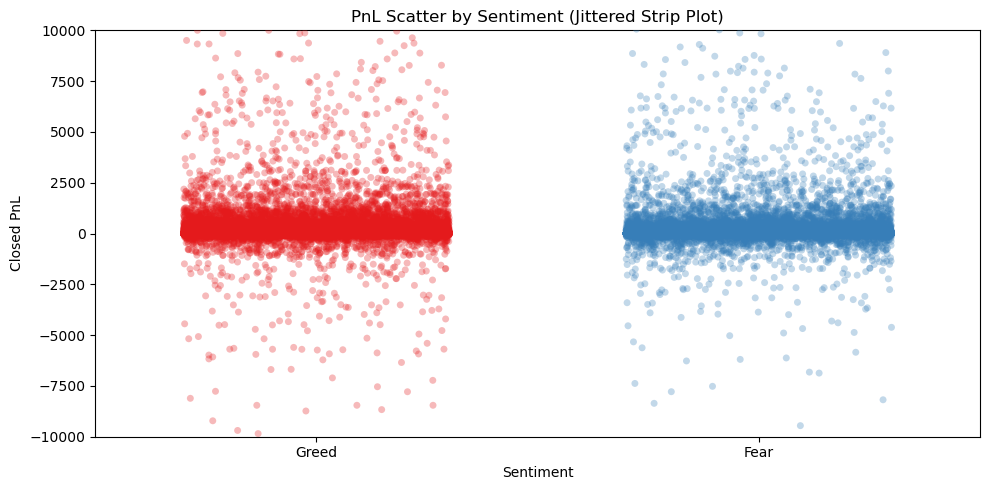

In [48]:
# Jittered Strip Plot: PnL Distribution
plt.figure(figsize=(10, 5))
sns.stripplot(data=merged_df, x='classification_simple', y='Closed PnL', jitter=0.3, palette='Set1', alpha=0.3)
plt.ylim(-10000, 10000)
plt.title('PnL Scatter by Sentiment (Jittered Strip Plot)')
plt.xlabel('Sentiment')
plt.ylabel('Closed PnL')
plt.tight_layout()
plt.show()

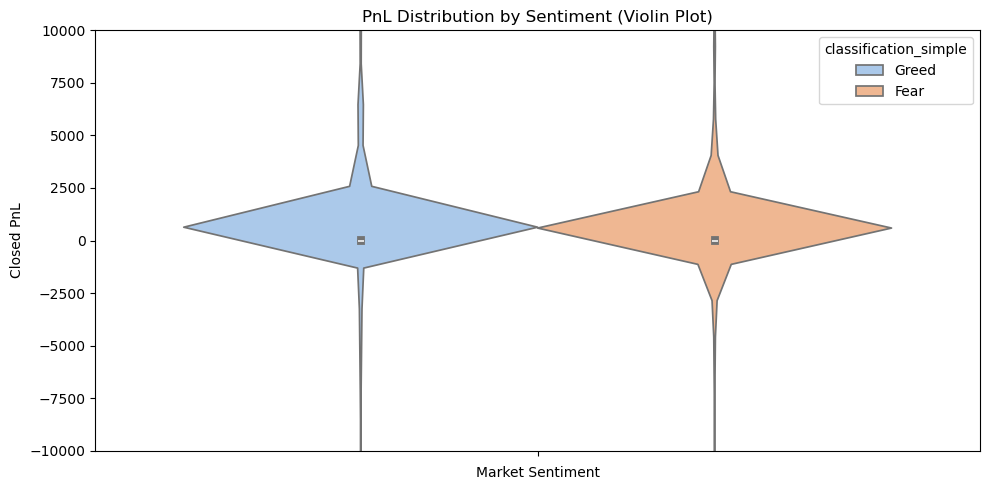

In [52]:
# Violin Plot: Better Distribution Visualization
plt.figure(figsize=(10, 5))
sns.violinplot(data=merged_df, hue='classification_simple', y='Closed PnL', palette='pastel', cut=0)
plt.ylim(-10000, 10000)
plt.title('PnL Distribution by Sentiment (Violin Plot)')
plt.xlabel('Market Sentiment')
plt.ylabel('Closed PnL')
plt.tight_layout()
plt.show()

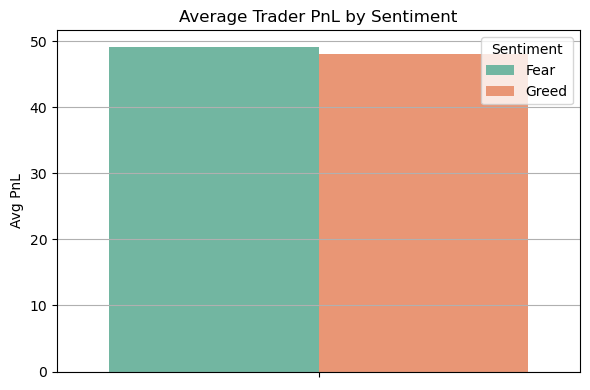

In [57]:
# Bar Chart: Average PnL by Sentiment
plt.figure(figsize=(6, 4))
sns.barplot(data=agg_by_sentiment, hue='Sentiment', y='Avg PnL', palette='Set2')
plt.title('Average Trader PnL by Sentiment')
plt.ylabel('Avg PnL')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [59]:
# 🧪 Hypothesis Testing: Mean PnL
fear_pnl = merged_df[merged_df['classification_simple'] == 'Fear']['Closed PnL']
greed_pnl = merged_df[merged_df['classification_simple'] == 'Greed']['Closed PnL']
t_stat, p_value = ttest_ind(fear_pnl, greed_pnl, equal_var=False)
print(f"\nHypothesis Test (Greed vs. Fear PnL):\nT-statistic = {t_stat:.4f}, P-value = {p_value:.4f}")
if p_value < 0.05:
    print("\n✅ There is a statistically significant difference in PnL between Greed and Fear days.")
else:
    print("\n❌ No significant difference in average PnL between Greed and Fear days.")


Hypothesis Test (Greed vs. Fear PnL):
T-statistic = 0.2602, P-value = 0.7947

❌ No significant difference in average PnL between Greed and Fear days.


In [69]:
# calculate win rate without warning
win_rate = (
    merged_df.groupby('classification_simple')['is_profitable']
    .mean()
    .reset_index()
    .rename(columns={'classification_simple': 'Sentiment', 'is_profitable': 'Win Rate (%)'})
)
win_rate['Win Rate (%)'] = round(win_rate['Win Rate (%)'] * 100, 2)


C:\Users\Dax\AppData\Local\Temp\ipykernel_20508\3205557449.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=win_rate, x='Sentiment', y='Win Rate (%)', palette='Set3')


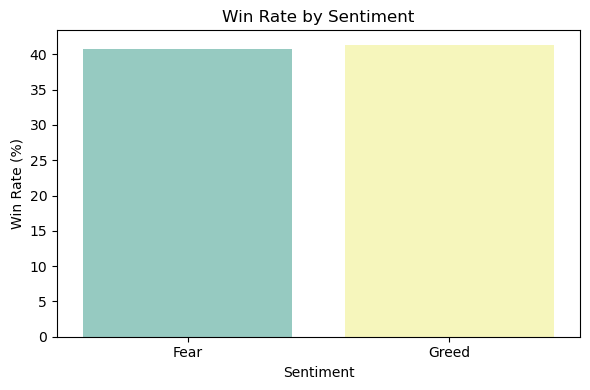

In [71]:
# 📊 Win Rate Bar Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=win_rate, x='Sentiment', y='Win Rate (%)', palette='Set3')
plt.title('Win Rate by Sentiment')
plt.ylabel('Win Rate (%)')
plt.tight_layout()
plt.show()

In [73]:
# Linear Regression: Predict PnL from sentiment score
model_df = merged_df[['scaled_sentiment', 'Closed PnL']].dropna()
X = model_df[['scaled_sentiment']]
y = model_df['Closed PnL']
model = LinearRegression()
model.fit(X, y)
print("\n🔮 PnL Prediction from Scaled Sentiment Score")
print(f"Coefficient: {model.coef_[0]:.4f}, Intercept: {model.intercept_:.4f}")


🔮 PnL Prediction from Scaled Sentiment Score
Coefficient: 7.4545, Intercept: 48.5493


In [95]:
print("\n📌 Interpretation:")

print("1. Most trades, whether on Greed or Fear days, result in little to no profit — the median PnL is near zero.")
print("2. On Fear days, traders tend to use larger trade sizes (position size is higher), possibly out of panic or urgency.")
print("3. Average PnL is slightly higher during Fear days, but the difference is very small and not statistically significant.")
print("4. The T-test confirms that this small difference in profit is likely due to chance, not a real performance gap.")
print("5. Win rate (i.e., percentage of profitable trades) is slightly better on Greed days — about 0.5% higher — not enough to impact strategy alone.")
print("6. The regression model shows a weak positive relationship between sentiment and PnL. This means when sentiment turns more greedy, traders tend to earn slightly more.")
print("7. However, the correlation is not strong enough to use sentiment as a standalone trading signal.")
print("8. Visualizations show large variation and outliers in both Fear and Greed periods — reinforcing that sentiment affects some traders but not the majority.")
print("\\n Overall Insight:\")
print("Market sentiment has a small influence on trader behavior, but it's not reliable enough alone for predicting success. Smart strategies would need to combine sentiment with other factors like volume, timing, or leverage.\")

SyntaxError: unterminated string literal (detected at line 11) (3183073935.py, line 11)

In [77]:
# ✅ Output Summary
print("\n📊 Win Rate by Sentiment:")
print(win_rate)
print("\n📈 Aggregate Metrics by Sentiment:")
print(agg_by_sentiment)



📊 Win Rate by Sentiment:
  Sentiment  Win Rate (%)
0      Fear         40.79
1     Greed         41.34

📈 Aggregate Metrics by Sentiment:
  Sentiment    Avg PnL  Median PnL  Avg Size USD   Avg Fee  Avg Exec Price
0      Fear  49.212077         0.0   7182.011019  1.397763    12327.789228
1     Greed  48.118246         0.0   4635.764077  1.011897    10821.413468
